## Import

In [62]:
import scipy.signal, scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

## Helper Functions

In [63]:
def plotDataSection(data, title, startTime=0, endTime=None, sampleRate=24e3, threshold = None):
    if endTime is None:
        time = np.linspace(0, len(data)/sampleRate, num=len(data))
        data_section = data
    else:
        idxStart = int(startTime*sampleRate)
        idxEnd = int(endTime*sampleRate)
        data_section = data[idxStart: idxEnd]
        time = np.linspace(startTime, endTime, num=(idxEnd - idxStart))
    fig, ax = plt.subplots()
    if threshold is not None:
        ax.axhline(y=threshold, color ='r', linestyle =':', linewidth = 3)
    
        fig.set_size_inches(20,5)
    ax.plot(time, data_section)
    ax.set_title(title)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [uv]')
    ax.grid(True)

    
    return fig, ax

def plotSectionMeanAndSTD(data, title, sampleRate=24e3):
    dataMean = data.mean(axis=0)
    time = np.linspace(0, len(dataMean)/sampleRate, num=len(dataMean))
    dataSTD = data.std(axis=0)
    fig, ax1 = plt.subplots()
    ax1.plot(time, dataMean, color='b')
    ax1.plot(time, dataMean + dataSTD, 'r.')
    ax1.plot(time, dataMean - dataSTD, 'r.')
    ax1.set_title(title)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('voltage [uv]')
    ax1.grid(True)
    # ax2 = fig.add_subplot(212)
    # ax2.plot(time, dataSTD)
    # ax2.set_xlabel('time [s]')
    # ax2.set_ylabel('STD')
    # ax2.grid(True)

def getPeakSections(data, idxPeaks, windowSizeBefore, windowSizeAfter):
    peakSections = []
    for i in idxPeaks:
        peakSections.append(data[i - windowSizeBefore: i + windowSizeAfter])
    return np.array(peakSections)

def removeOutOfBoundIdx(idx, lowBound, upBound):
    '''Remove the idx that are too close to the begining or end 
    defined by lowBound and upBound.
    Needed to avoid index out of bound error when cutting data into small sections.
    '''
    return idx[np.logical_and(idx > lowBound, idx < upBound)]

def visualize_alignment(data, cluster_center = None, title = ' ', groundTruth = None):
    time = np.linspace(0, len(data[0])/sampleRate, num=len(data[0]))
    fig, ax1 = plt.subplots()
    for x in data:
        ax1.set_title(title)
        ax1.plot(time, x, color='b', linewidth=0.15)
        ax1.set_xlabel('time [s]')
        ax1.set_ylabel('voltage [uv]')
        ax1.grid(True)
    if cluster_center is not None:
        ax1.plot(time, cluster_center, color= 'aqua', linewidth = 4, label = f'Average Spike form ({len(data)} spikes)')
    if groundTruth is not None:
        dataMean = groundTruth.mean(axis=0)
        ax1.plot(time, dataMean, color = 'orange', linewidth = 2, label = f'Average Ground truth ({len(groundTruth)} spikes)')
    ax1.legend()

## Parameters

Specify here what dataset to analyze:
_______________________________________________________________________________________________________________________________

In [64]:
dataset = 1


________________________________________________________________________________________________________________________________________

In [65]:
sampleRate = 24e3
heightThreshold = 40
distanceThreshold = 10
numSpikeTypes = 3
dataFile = ['sample_1.mat', 'sample_2.mat', 'sample_3.mat', 'sample_4.mat', 'sample_5.mat']
filtering = [True, True, True, True, True]
median_mult = [4, 4, 5, 5, 4]
numPC = 2
numSpikes = [3, 3, 3, 3, 4]
windowSizeBefore_0 = [ 8,  8,  8,  8,  8]
windowSizeAfter_0 =  [64, 64, 64, 64, 64]

windowSizeBefore_1 = [11, 10, 10, 10, 10]
windowSizeAfter_1 =  [61, 62, 62, 62, 62]

windowSizeBefore_2 = [ 4, 11, 10,  4,  3]
windowSizeAfter_2 =  [68, 61, 62, 68, 69]


dataset -=1 ## decrease the variable by one, such that one does not have to do this in every bracket hereafter

Get Data

In [66]:
data = scipy.io.loadmat(dataFile[dataset])
origData = data['data'].flatten()
spike_times = data['spike_times'][0][0][0]
spike_class = data['spike_class'][0][0][0]
windowSizeBefore = 30
windowSizeAfter = 70
spike_times_type0 = spike_times[np.where(spike_class == 0)]
spike_times_type0 = removeOutOfBoundIdx(
    spike_times_type0, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type1 = spike_times[np.where(spike_class == 1)]
spike_times_type1 = removeOutOfBoundIdx(
    spike_times_type1, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type2 = spike_times[np.where(spike_class == 2)]
spike_times_type2 = removeOutOfBoundIdx(
    spike_times_type2, windowSizeBefore, len(origData) - windowSizeAfter - 80)

print(f'dataset loaded, origial data shape: {origData.shape}')

recLength = len(origData) / sampleRate
print(f'recording length {recLength:8.2f} seconds.')

dataset loaded, origial data shape: (2880000,)
recording length   120.00 seconds.


## Filtering

In [67]:
sos = scipy.signal.iirfilter(2, [300,3000], btype='bandpass',ftype='butter', rp=3000, rs=300, output='sos',fs=sampleRate)
filteredData = scipy.signal.sosfiltfilt(sos, origData)

Checking if we filter (since we always do this is kinda pointless but whatever)

In [68]:
if filtering[dataset]:
    data_to_use = filteredData
else:
    data_to_use = origData

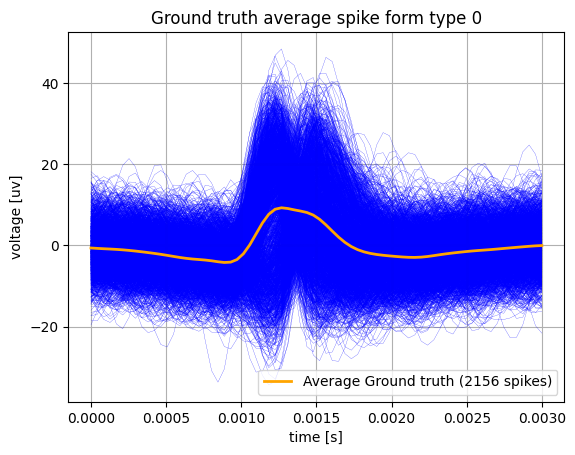

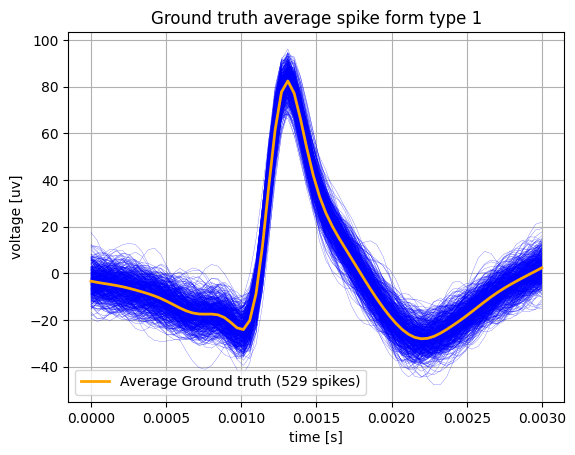

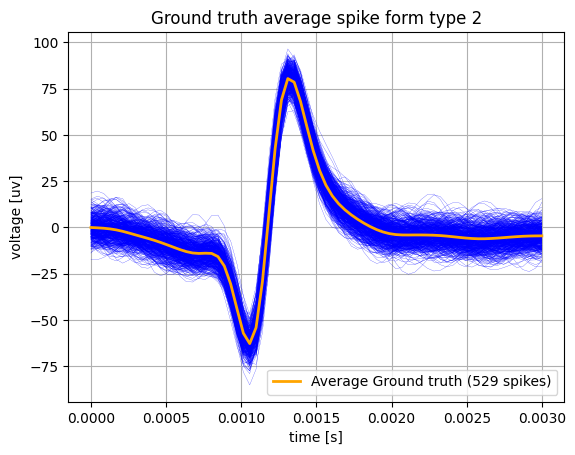

In [69]:
spikeSectionType0 = getPeakSections(data_to_use, spike_times_type0, 
    windowSizeBefore_0[dataset], windowSizeAfter_0[dataset])
spikeSectionType1 = getPeakSections(data_to_use, spike_times_type1, 
    windowSizeBefore_1[dataset], windowSizeAfter_1[dataset])
spikeSectionType2 = getPeakSections(data_to_use, spike_times_type2, 
    windowSizeBefore_2[dataset], windowSizeAfter_2[dataset])

visualize_alignment(spikeSectionType0, title = f"Ground truth average spike form type 0", groundTruth = spikeSectionType0)
visualize_alignment(spikeSectionType1, title = f"Ground truth average spike form type 1", groundTruth = spikeSectionType1)
visualize_alignment(spikeSectionType2, title = f"Ground truth average spike form type 2", groundTruth = spikeSectionType2)

## Subtracting mean (not really needed)

In [70]:
# plotDataSection(origData, 'raw data', 0.5, 0.8, sampleRate)
# plotDataSection(origData, 'raw data', 0.5, 0.65, sampleRate)
# plotDataSection(filteredData, 'filter data', 0.5, 0.65, sampleRate)
mean = np.mean(filteredData)
print(mean)

filteredData -= mean

new_mean = np.mean(filteredData)
print(new_mean)

-2.8490277169660934e-05
-7.929459558100562e-18


## Find Peaks

In [71]:
median = np.median(np.abs(data_to_use)/0.6745)
heightThreshold = median_mult[dataset] * median
distanceThreshold = 72
print(f'median = {median},       threshold = {heightThreshold}')

idxPeaks, peakProperties = scipy.signal.find_peaks(
    data_to_use, height=heightThreshold, distance=distanceThreshold)
idxPeaks = idxPeaks[idxPeaks > windowSizeBefore]
print(f'number of peaks found: {len(idxPeaks)}')
print(f'number of spikes in dataset: {len(spike_times)}')

median = 5.72853898088991,       threshold = 22.91415592355964
number of peaks found: 2062
number of spikes in dataset: 3214


(<Figure size 2000x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Filtered Data Snippet'}, xlabel='time [s]', ylabel='voltage [uv]'>)

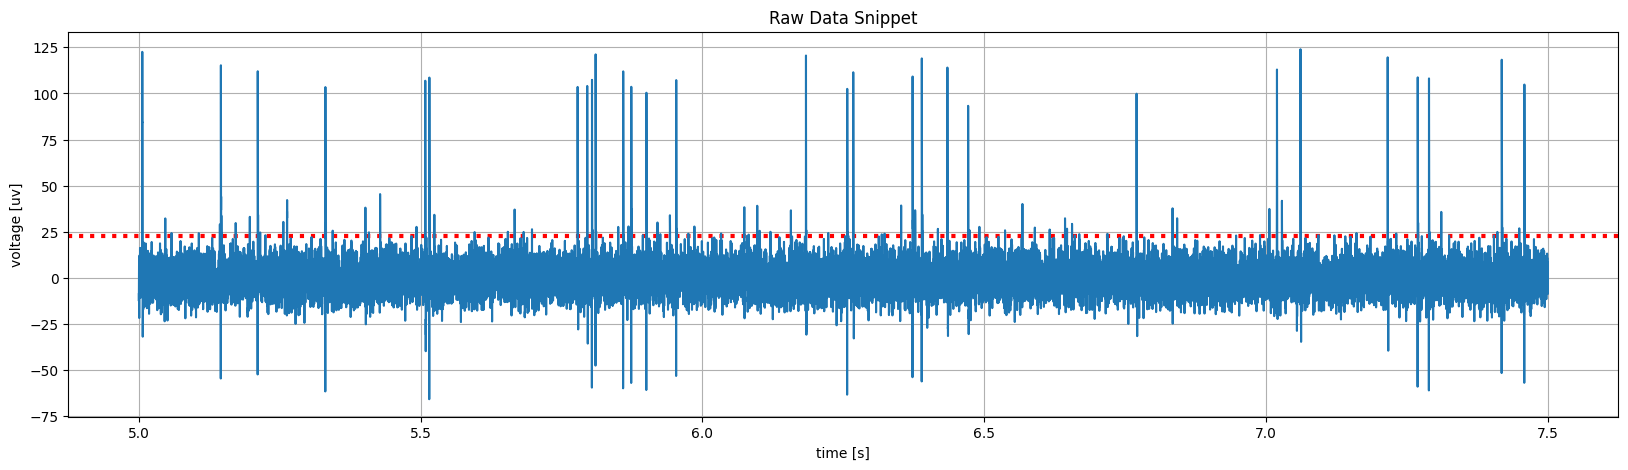

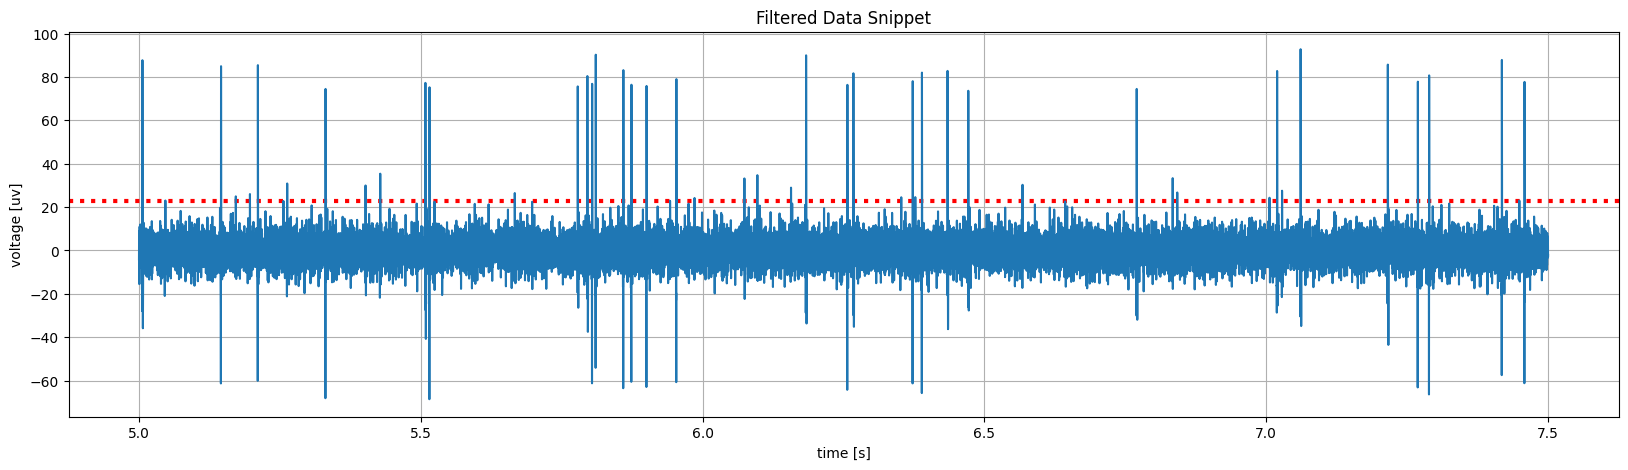

In [72]:
start_time = 5
end_time = 7.5

plotDataSection(origData, 'Raw Data Snippet', start_time, end_time, sampleRate, threshold = heightThreshold)
plotDataSection(filteredData, 'Filtered Data Snippet', start_time, end_time, sampleRate, threshold = heightThreshold)

## Get Windows around peaks

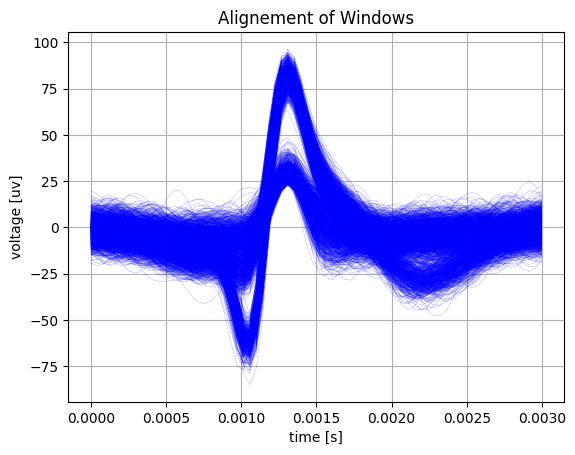

In [73]:
##window size is equal to 72 timesteps = 3ms
windowSizeBefore = 31
windowSizeAfter = 41


peakSections = getPeakSections(filteredData, idxPeaks, windowSizeBefore, windowSizeAfter)

time = np.linspace(0, len(peakSections[0])/sampleRate, num=len(peakSections[0]))
fig, ax1 = plt.subplots()

for x in peakSections:
    ax1.plot(time, x, color='b', linewidth=0.1)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('voltage [uv]')
    ax1.set_title('Alignment of Windows')
    ax1.grid(True)


## PCA

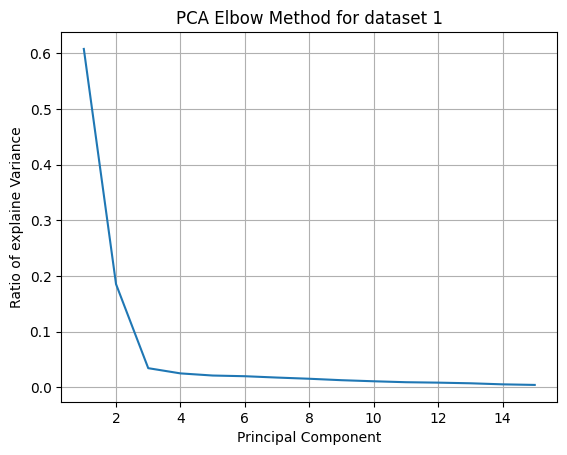

In [74]:
pcaElbow = PCA()
pcaElbow.fit(peakSections)
amount = len(pcaElbow.components_)

plt.plot( np.arange(amount)[0:15]+1, pcaElbow.explained_variance_ratio_[0:15])
plt.xlabel('Principal Component')
plt.ylabel('Ratio of explaine Variance')
plt.grid()
plt.title(f'PCA Elbow Method for dataset {dataset+1}')
plt.show()

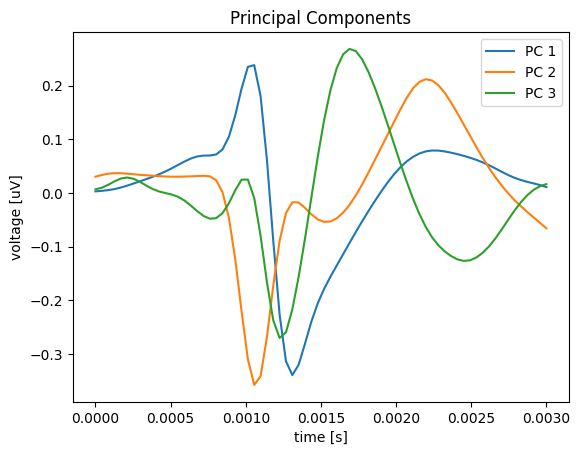

In [75]:
numPC = 3

pca = PCA(n_components=numPC)
pca.fit(peakSections)
peakPC = pca.transform(peakSections)


time = np.linspace(0, len(pca.components_[0])/sampleRate, num=len(pca.components_[0]))
for i in range(numPC):
    plt.plot(time, pca.components_[i], label = f'PC {i+1}')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('voltage [uV]')
plt.title('Principal Components')
plt.show()

Scatterplot just to show the PCA, the colored version is below

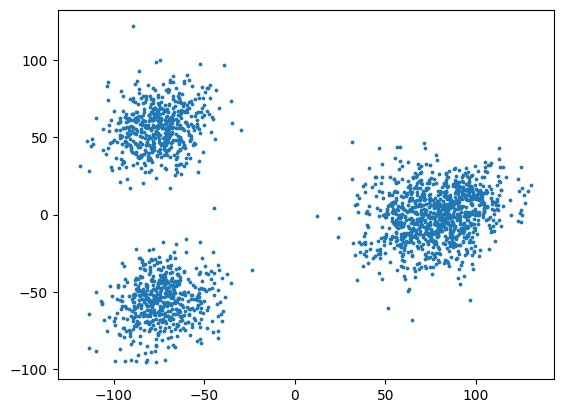

In [76]:
plt.scatter(peakPC[:, 0],peakPC[:, 1], s = 3)
plt.show()

Do k-means

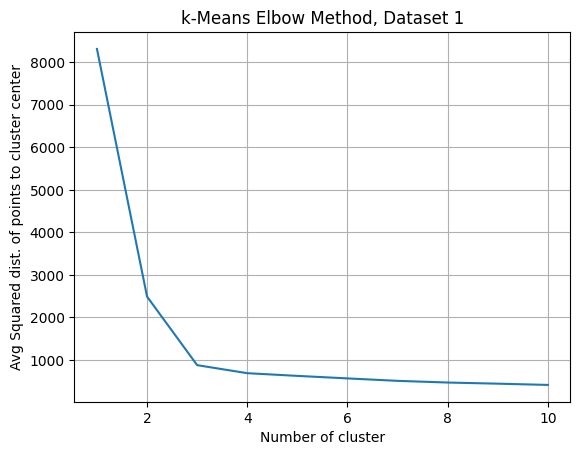

In [77]:
max_k = 10
k = np.arange(max_k)+1
inertia = np.zeros(max_k)

for i in range(0, max_k):
    kMeanCluster = KMeans(n_clusters=i+1, n_init=10)
    kMeanCluster.fit(peakPC)
    inertia[i] = kMeanCluster.inertia_/len(kMeanCluster.labels_)

plt.plot(k, inertia)
plt.xlabel("Number of cluster")
plt.ylabel('Avg Squared dist. of points to cluster center')
plt.title(f'k-Means Elbow Method, Dataset {dataset+1}')
plt.grid()
plt.show()

In [78]:
numSpikeTypes = numSpikes[dataset]

kMeanCluster = KMeans(n_clusters=numSpikeTypes, n_init=10)
kMeanCluster.fit(peakPC)
# for i in range(numSpikeTypes):
#     plotDataSection(
#         pca.inverse_transform(kMeanCluster.cluster_centers_[i]), f'spike type {i}')
#     # plotDataSection(kMeanCluster.cluster_centers_[i], f'spike type {i}')

KMeans(n_clusters=3)

In [79]:
# compare number of peaks found through clustering to ground truth
print('compare number of peaks found through clustering to ground truth')

for i in range(numSpikeTypes):
    print(f'{sum(kMeanCluster.labels_ == i)} type {i} spikes were found through clustering')

print(f'\n{len(spike_times_type0)} type 0 spikes in ground truth')
print(f'{len(spike_times_type1)} type 1 spikes in ground truth')
print(f'{len(spike_times_type2)} type 2 spikes in ground truth')

compare number of peaks found through clustering to ground truth
1004 type 0 spikes were found through clustering
528 type 1 spikes were found through clustering
530 type 2 spikes were found through clustering

2156 type 0 spikes in ground truth
529 type 1 spikes in ground truth
529 type 2 spikes in ground truth


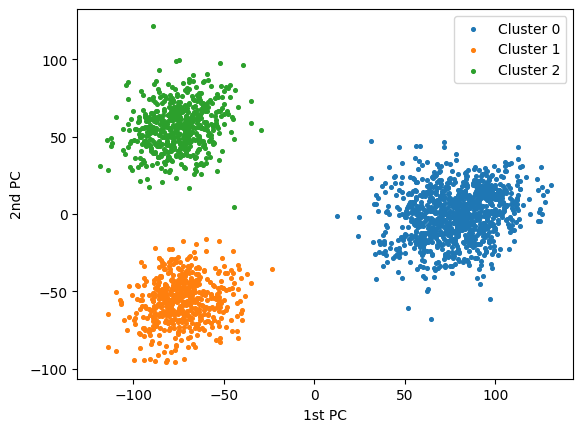

In [80]:
fig, ax = plt.subplots()
for idxCluster in range(numSpikeTypes):
    clusterPC = peakPC[kMeanCluster.labels_ == idxCluster]
    ax.scatter(clusterPC[:, 0], clusterPC[:, 1], label=f'Cluster {idxCluster}', s = 7)
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.legend()

Short explanation: first you have to assign each generated cluster the correct real spike type int the first 4 variables (4 because in dataset 5 I used 4 cluster centers, so in general ignore the 4th), then run the cell (just the cell or the order of the clusters change) again to get the correct analysis 

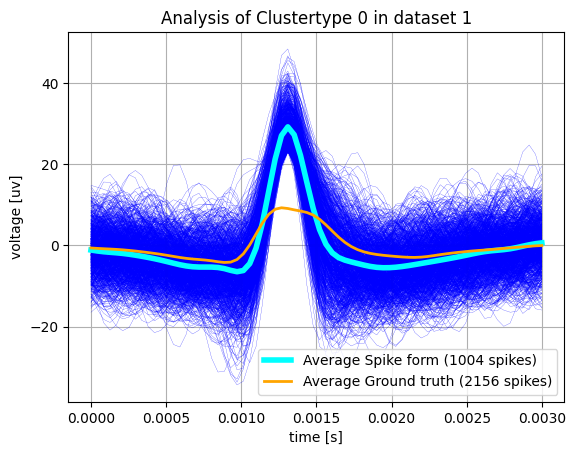

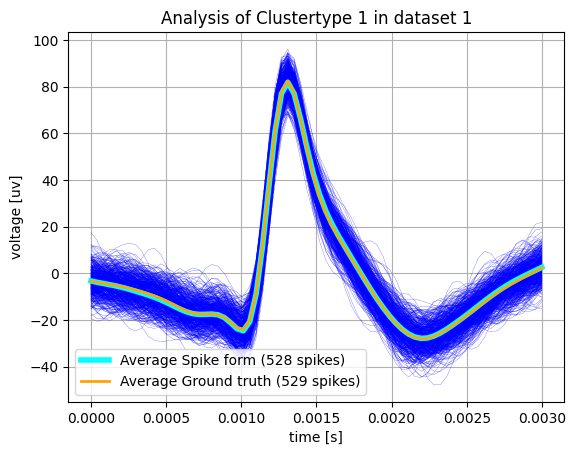

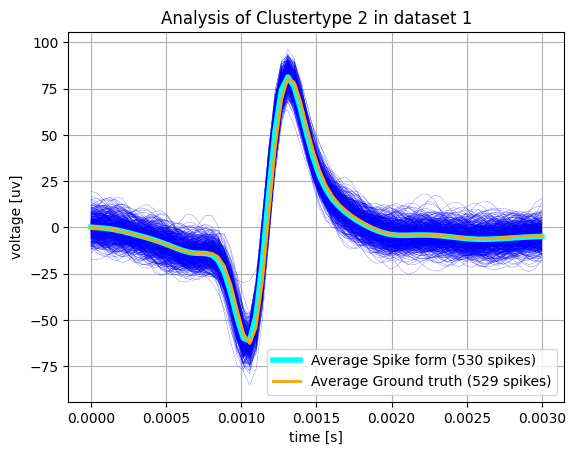

In [83]:
cluster_0_real_type = 0
cluster_1_real_type = 1
cluster_2_real_type = 2

cluster_3_real_type = 0

groundTruth = [spikeSectionType0, spikeSectionType1, spikeSectionType2]
clusters_real = [cluster_0_real_type, cluster_1_real_type, cluster_2_real_type, cluster_3_real_type]

for i in range(numSpikeTypes):
    visualize_alignment(peakSections[kMeanCluster.labels_ == i], pca.inverse_transform(kMeanCluster.cluster_centers_[i]), f"Analysis of Clustertype {i} in dataset {dataset+1}", groundTruth = groundTruth[clusters_real[i]])

Summary

In [82]:
print(f'Dataset = {dataset+1}')
print(f'Height Threshold = {heightThreshold}')
print(f'Principal Components = {numPC}')
print(f'CLusters = {numSpikeTypes}')

Dataset = 1
Height Threshold = 22.91415592355964
Principal Components = 3
CLusters = 3
